# XGBoost - Lab

## Introduction

In this lab, we'll install the popular [XGBoost](http://xgboost.readthedocs.io/en/latest/index.html) library and explore how to use this popular boosting model to classify different types of wine using the [Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality) from the UCI Machine Learning Dataset Repository.  

## Objectives

You will be able to:

- Fit, tune, and evaluate an XGBoost algorithm

## Installing XGBoost

Run this lab on your local computer.

The XGBoost model is not currently included in scikit-learn, so we'll have to install it on our own.  To install XGBoost, you'll need to use `pip`. 

To install XGBoost, follow these steps:

1. Open up a new terminal window 
2. Activate your conda environment
3. Run `pip install xgboost`
4. Once the installation has completed, run the cell below to verify that everything worked 

In [1]:
from xgboost import XGBClassifier

Run the cell below to import everything we'll need for this lab. 

In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Loading the Data

The dataset we'll be using for this lab is currently stored in the file `'winequality-red.csv'`.  

In the cell below, use pandas to import the dataset into a dataframe, and inspect the `.head()` of the dataframe to ensure everything loaded correctly. 

In [3]:
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


For this lab, our target column will be `'quality'`.  That makes this a multiclass classification problem. Given the data in the columns from `'fixed_acidity'` through `'alcohol'`, we'll predict the quality of the wine.  

This means that we need to store our target variable separately from the dataset, and then split the data and labels into training and test sets that we can use for cross-validation. 

### Splitting the Data

In the cell below:

- Assign the `'quality'` column to `y` 
- Drop this column (`'quality'`) and assign the resulting DataFrame to `X` 
- Split the data into training and test sets. Set the `random_state` to 42   

In [4]:
y = df['quality']
X = df.drop('quality', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Preprocessing the Data

These are the current target values:

In [5]:
y_train.value_counts().sort_index()

3      9
4     40
5    517
6    469
7    151
8     13
Name: quality, dtype: int64

XGBoost requires that classification categories be integers that count up from 0, not starting at 3. Therefore you should instantiate a `LabelEncoder` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)) and convert both `y_train` and `y_test` into arrays containing label encoded values (i.e. integers that count up from 0).

In [6]:
# Instantiate the encoder
encoder = LabelEncoder()

# Fit and transform the training data
y_train = pd.Series(encoder.fit_transform(y_train))

# Transform the test data
y_test = pd.Series(encoder.fit_transform(y_test))

Confirm that the new values start at 0 instead of 3:

In [7]:
print("Training Data:")
print(y_train.value_counts())
print()
print("Testing Data:")
print(y_test.value_counts())

Training Data:
2    517
3    469
4    151
1     40
5     13
0      9
dtype: int64

Testing Data:
3    169
2    164
4     48
1     13
5      5
0      1
dtype: int64


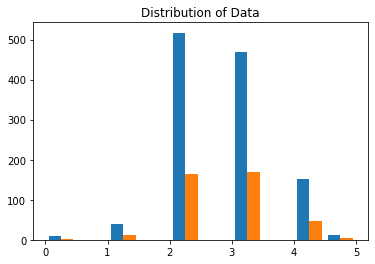

In [8]:
# Your code here to inspect the values of y_train and y_test
plt.hist([y_train, y_test], label=['Training Data', 'Testing Data'])
plt.title("Distribution of Data");

### Building an XGBoost Model

Now that you have prepared the data for modeling, you can use XGBoost to build a model that can accurately classify wine quality based on the features of the wine!

The API for `xgboost` is purposefully written to mirror the same structure as other models in scikit-learn.  

In [9]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 100.0%
Validation accuracy: 68.0%


## Tuning XGBoost

The model had a somewhat lackluster performance on the test set compared to the training set, suggesting the model is beginning to overfit to the training data. Let's tune the model to increase the model performance and prevent overfitting. 

You've already encountered a lot of parameters when working with Decision Trees, Random Forests, and Gradient Boosted Trees.

For a full list of model parameters, see the [XGBoost Documentation](http://xgboost.readthedocs.io/en/latest/parameter.html).

Examine the tunable parameters for XGboost, and then fill in appropriate values for the `param_grid` dictionary in the cell below. 

**_NOTE:_** Remember, `GridSearchCV` finds the optimal combination of parameters through an exhaustive combinatoric search.  If you search through too many parameters, the model will take forever to run! To ensure your code runs in sufficient time, we restricted the number of values the parameters can take.  

In [24]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6],
    'min_child_weight': [1, 2],
    'subsample': [0.6, 0.7],
    'n_estimators': [100],
}

Now that we have constructed our `params` dictionary, create a `GridSearchCV` object in the cell below and use it to iteratively tune our XGBoost model.  

Now, in the cell below:

* Create a `GridSearchCV` object. Pass in the following parameters:
    * `clf`, the classifier
    * `param_grid`, the dictionary of parameters we're going to grid search through
    * `scoring='accuracy'`
    * `cv=None`
    * `n_jobs=1`
* Fit our `grid_clf` object and pass in `X_train` and `y_train`
* Store the best parameter combination found by the grid search in `best_parameters`. You can find these inside the grid search object's `.best_params_` attribute 
* Use `grid_clf` to create predictions for the training and test sets, and store them in separate variables 
* Compute the accuracy score for the training and test predictions  

In [25]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)

grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 4
min_child_weight: 1
n_estimators: 100
subsample: 0.7

Training Accuracy: 92.49%
Validation accuracy: 68.0%


## Summary

Great! You've now successfully made use of one of the most powerful boosting models in data science for modeling.  We've also learned how to tune the model for better performance using the grid search methodology we learned previously. XGBoost is a powerful modeling tool to have in your arsenal. Don't be afraid to experiment with it! 